In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from math import pi,log
import matplotlib as mpl

# import basic plot tools
from qiskit.visualization import plot_histogram

from qiskit.quantum_info import Statevector

# Incrementers and Decrementers

Incrementers and decrementers are needed in order to calculate the neighbouring vertices of a given vertex.

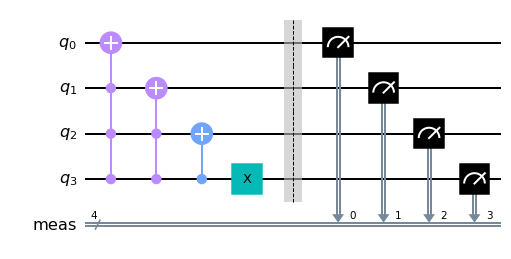

In [2]:
def increment(n_adder):
    
    qc = QuantumCircuit(n_adder)
    
    for i in range(n_adder-2):
        qc.mcx(list(range(i+1, n_adder)),i)
    
    qc.cx(n_adder-1, n_adder-2)
    qc.x(n_adder-1)
    
    U_inc = qc.to_gate()
    U_inc.name = "U$_{inc}$"
    
    return U_inc

def decrement(n_sub):
    
    qc = QuantumCircuit(n_sub)
    
    qc.x(n_sub-1)
    qc.cx(n_sub-1, n_sub-2)
    
    for i in range(n_sub-3, -1, -1):
        qc.mcx(list(range(i+1, n_sub)),i)
               
    U_dec = qc.to_gate()
    U_dec.name = "U$_{dec}$"
    
    return U_dec

qc = QuantumCircuit(4)

qc.append(increment(4), [0,1,2,3])
qc.measure_all()

qc.decompose().draw('mpl')

# Shift Operation $S$

$S$ takes the walker's position and a direction and outputs the new position after taking one step in the given direction. 

For example, $S(\lvert00\rangle_{pos} \otimes\lvert00\rangle_{dir}) = \lvert01\rangle_{pos}\otimes\lvert00\rangle_{dir}$.


In [3]:
def shift(n_dir, n_pos):
    
    HALF_N = math.ceil(n_pos/2)
    
    qr = QuantumRegister(n_dir+n_pos)
    q_dir = qr[:n_dir]
    q_pos = qr[n_dir:]
    
    qc = QuantumCircuit(qr)
    
    # if direction is 00 (RIGHT)
    qc.x(q_dir)
    qc.append(increment(HALF_N).control(2), q_dir+q_pos[HALF_N:])
    qc.x(q_dir)
    
    # if direction is 01 (DOWN)
    qc.x(q_dir[0])
    qc.append(increment(HALF_N).control(2), q_dir+q_pos[:-HALF_N])
    qc.x(q_dir[0])
    
    # if direction is 10 (LEFT)
    qc.x(q_dir[1])
    qc.append(decrement(HALF_N).control(2), q_dir+q_pos[HALF_N:])
    qc.x(q_dir[1])
    
    # if direction is 11 (UP)
    qc.append(decrement(HALF_N).control(2), q_dir+q_pos[:-HALF_N])
    
    
    U_shift = qc.to_gate()
    U_shift.name = "U$_{shift}$"
    return U_shift


In [11]:
'''HELPER FUNCTIONS'''

def bitshift(b, pos):
    return str(int(int(b) + 10**pos))[1:]


def get_start_bits(index, n_pos):
    ''' 
    Returns list of bits to flip to set start location, based on desired index
    
    '''
    
    qbits = []
    pos = n_pos/2 # n_positions for this half of the bitstring
    
    left = bin(index[0])[2:]
    right = bin(index[1])[2:]
    
    bitstring = '00' + bitshift(left, pos) + bitshift(right, pos)
    
    for i in range(len(bitstring)):
        if bitstring[i] == '1':
            qbits.append(i)
            
    return qbits
    
def round_remove_zeroes(np_dict):
    for a,d in np.ndenumerate(np_dict):
        for k,v in d.items():
            d[k] = round(v, 5)
    
    new_dict = {}
    for a,d in np.ndenumerate(np_dict):
        for k,v in d.items():
            if v:
                new_dict[k] = v
                
    return new_dict

def multiply_grid(grid, factor):
    f = np.ones((factor, factor))
    return np.kron(f, grid) # tensor product

'''print start state'''
#inf = multiply_grid(sg, 2)
# print(inf)

'print start state'

# The full Quantum Walk algorithm

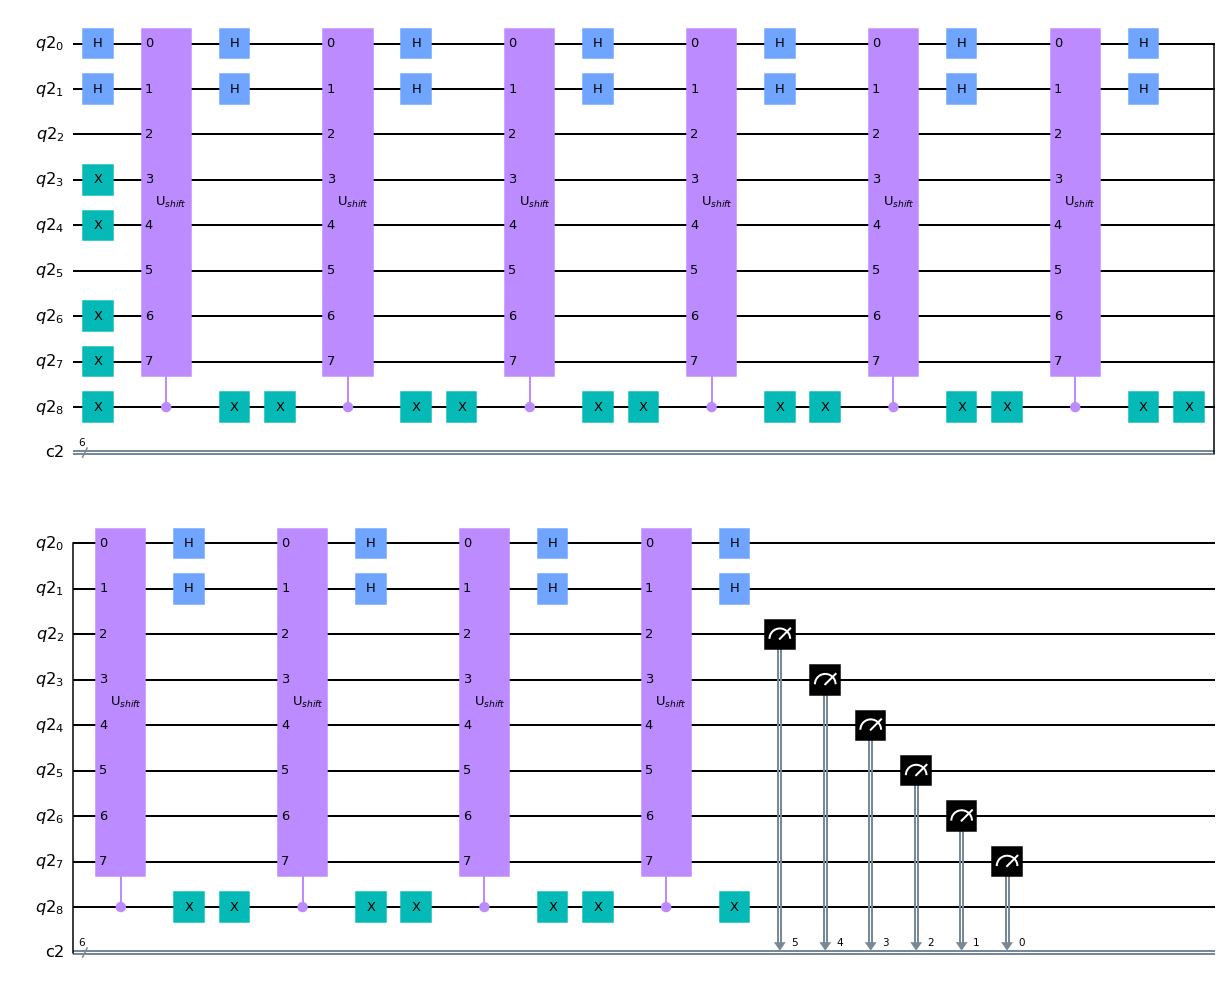

In [8]:
n_dir = 2 # number of qubits required to represent all directions
n_pos = 6 # number of qubits required to represent all positions
iterations = 10
start = (3,3) # (row, column)

qwalk_reg = QuantumRegister(n_dir+n_pos+1)

# allocating qubits
q_dir = qwalk_reg[:n_dir]
q_pos = qwalk_reg[n_dir:n_dir+n_pos]
q_anc = qwalk_reg[n_dir+n_pos]

# lists of indices
dir_ind = list(range(n_dir))
pos_ind = list(range(n_dir+n_pos))[2:]
anc_ind = n_dir+n_pos

qwalk_circ = QuantumCircuit(qwalk_reg, ClassicalRegister(n_pos))

# set up the initial position
if get_start_bits(start, n_pos):
    qwalk_circ.x(get_start_bits(start, n_pos)) # start in chosen position
    
# set up the initial direction(s)
for qubit in q_dir:
    qwalk_circ.h(qubit)


## Add state harvesting
states = []

states.append(Statevector.from_instruction(qwalk_circ))
for i in range(iterations):
    
    ''' Uncomment to add target state (Sticky walk) functionality'''
    #qwalk_circ.mcx(pos_ind, anc_ind) oracle, target is |11111..1>
    
    '''controlled shift where ancilla is control
      only shift if we are in a non-target state'''
    qwalk_circ.x(q_anc)
    qwalk_circ.append(shift(n_dir, n_pos).control(1), [anc_ind]+dir_ind+pos_ind)

    
    # add state to list
    states.append(Statevector.from_instruction(qwalk_circ))
    
    qwalk_circ.x(q_anc)
    
    '''Uncomment to add target state (Sticky walk) functionality'''
    #qwalk_circ.reset(q_anc)

    qwalk_circ.h(q_dir)
    
    
qwalk_circ.measure(pos_ind, list(range(n_pos))[::-1]) # reversed to print in Big Endian form

qwalk_circ.draw('mpl')

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Plots

## Plotting of a Hadamard walk on an 8 x 8 lattice

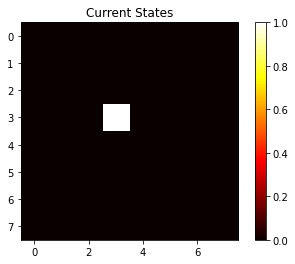

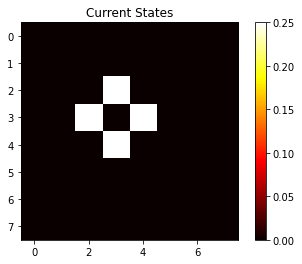

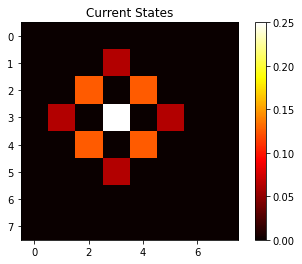

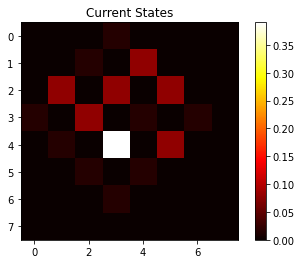

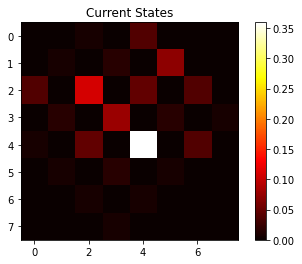

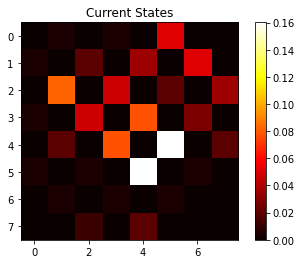

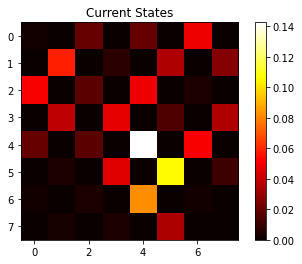

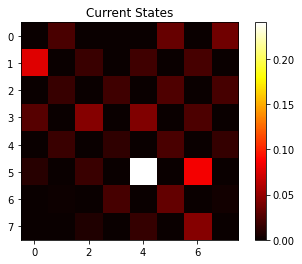

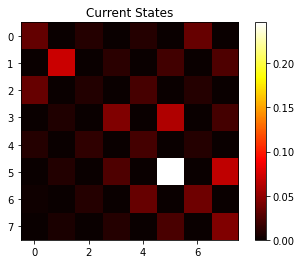

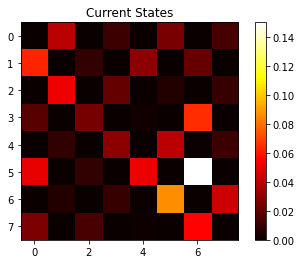

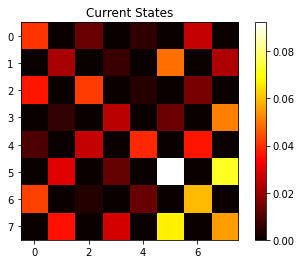

In [13]:
# PLOTTING FOR 8 x 8 GRID
sum_data = np.zeros((8,8))
meta_states = []

for state in states:
  
    # creating a dataset
    # data is an array with four sub 
    # arrays with 10 elements in each
    
    np_dict = round_remove_zeroes(np.array(state.probabilities_dict([7,6,5,4,3,2])))         
    #print("Position qubits:",np_dict)
    
    data = np.around(np.array(state.probabilities([7,6,5,4,3,2])), 5)
    data = np.reshape(data, (8,8))
    sum_data = sum_data + data
    meta_states.append(sum_data)
    d = state.probabilities_dict([7,6,5,4,3,2])
    
    # customizing plot
    plt.title("Current States")
    pixel_plot = plt.imshow(
      data, cmap='hot')

    plt.colorbar(pixel_plot)
    
    #print("Data:",data)
    plt.show(pixel_plot)
    


## Plotting of nine 8 x 8 subspaces each carrying out a Hadamard walk

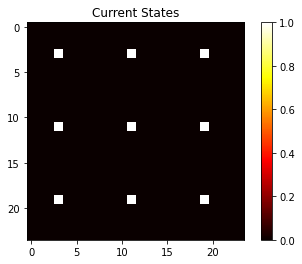

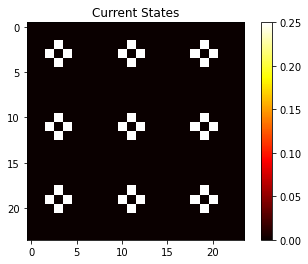

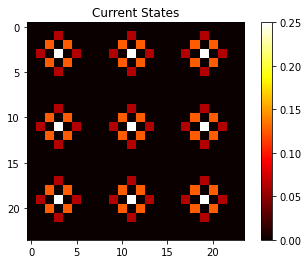

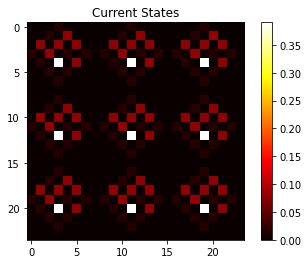

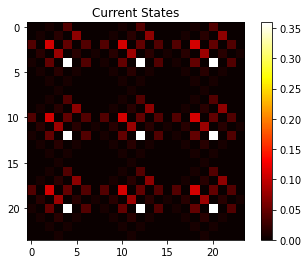

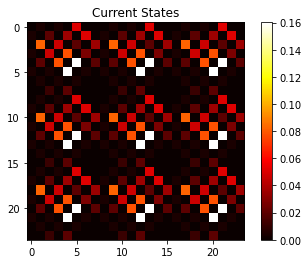

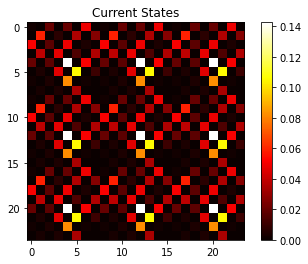

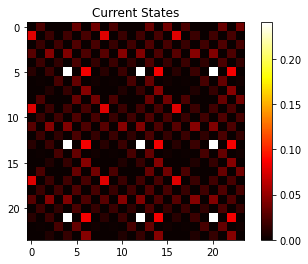

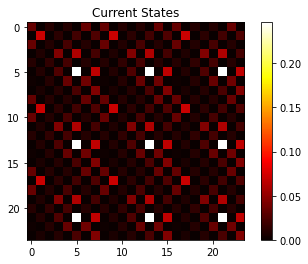

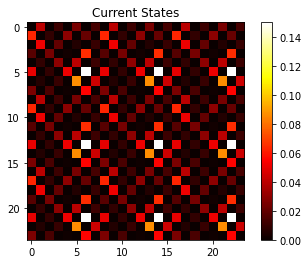

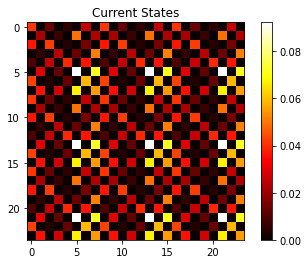

In [14]:
for state in states:
  
    np_dict = round_remove_zeroes(np.array(state.probabilities_dict([7,6,5,4,3,2])))         
    #print("Position qubits:",np_dict)
    
    data = np.around(np.array(state.probabilities([7,6,5,4,3,2])), 5)
    data = np.reshape(data, (8,8))

    
    # customizing plot
    plt.title("Current States")
    pixel_plot = plt.imshow(
      multiply_grid(data, 3), cmap='hot')

    plt.colorbar(pixel_plot)
    
    #print("Data:",data)
    plt.show(pixel_plot)
    

## Plotting of a Hadamard walk with overlaid probabilities

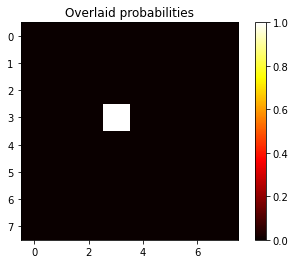

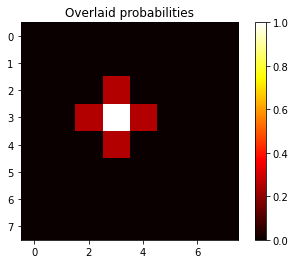

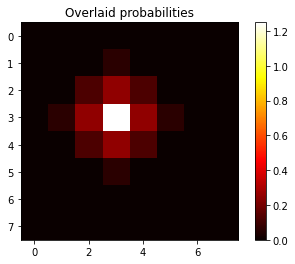

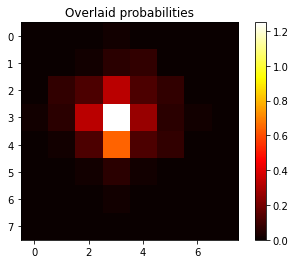

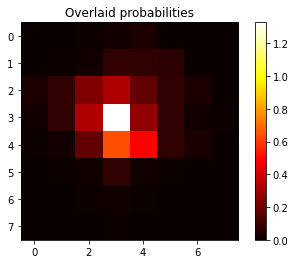

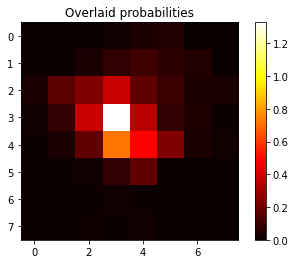

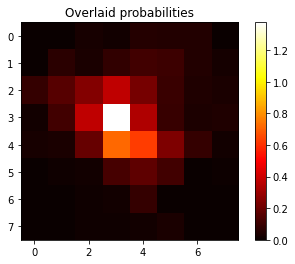

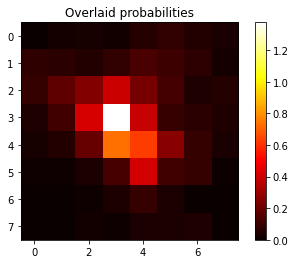

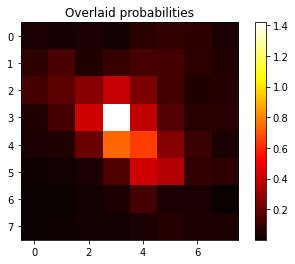

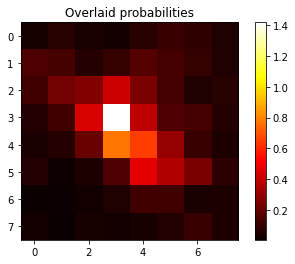

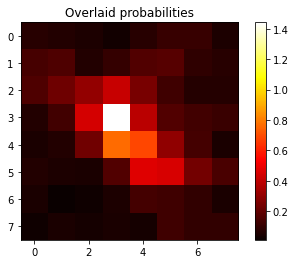

In [15]:
for data in meta_states:
    plt.title("Overlaid probabilities")
    pixel_plot = plt.imshow(
      data, cmap='hot')

    plt.colorbar(pixel_plot)
    plt.show(pixel_plot)

## Plotting of nine subspaces carrying out Hadamard walks with overlaid probabilities

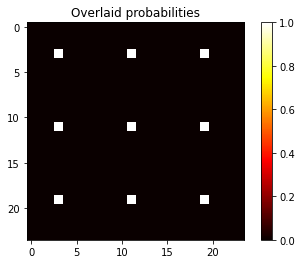

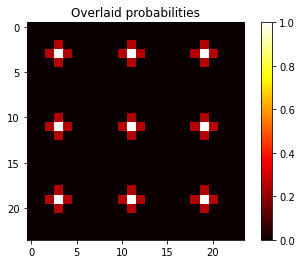

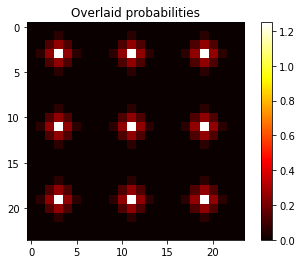

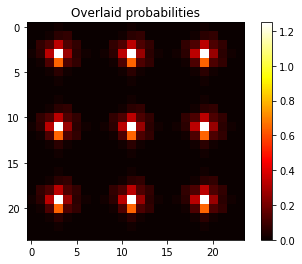

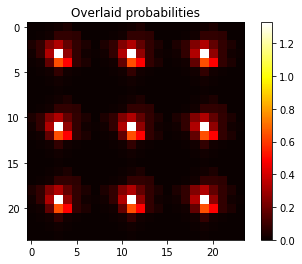

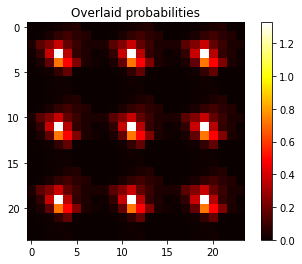

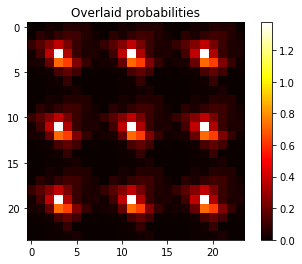

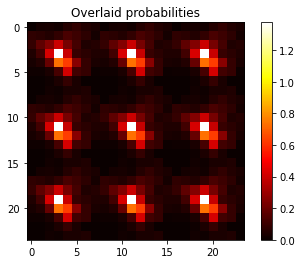

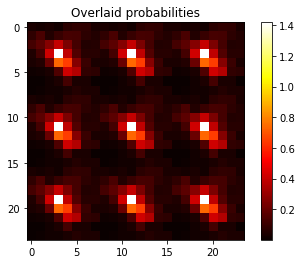

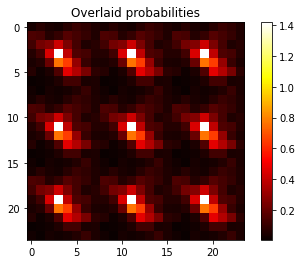

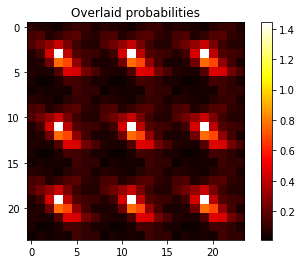

In [16]:
for data in meta_states:
    plt.title("Overlaid probabilities")
    pixel_plot = plt.imshow(
      multiply_grid(data, 3), cmap='hot')

    plt.colorbar(pixel_plot)
    plt.show(pixel_plot)

## High contrast (black and white) Hadamard walk plot

In [17]:
'''HELPER FUNCTIONS'''

def start_grid(start_index, n_pos):
    grid = np.zeros((int(np.sqrt(2**n_pos)), int(np.sqrt(2**n_pos))))
    grid[start_index[0],start_index[1]] = 1
    return grid

sg = start_grid((3, 5), 6)
#print(sg)

def wrap(i, l):
    if i == -1:
        return l-1
    else:
        return i % l

def grid_step(grid):
    l = len(grid)
    new = np.zeros((l,l))
    
    for i in range(l):
        for j in range(l):
            
            new[i,j] = (
                grid[wrap(i+1, l), wrap(j, l)] +
                grid[wrap(i-1, l), wrap(j, l)] +
                grid[wrap(i, l), wrap(j+1, l)] +
                grid[wrap(i, l), wrap(j-1, l)]
            )
            
    return new

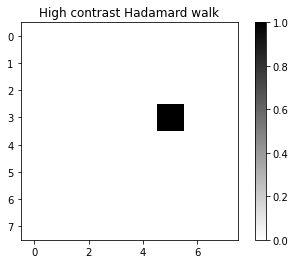

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


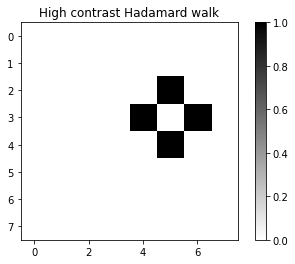

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 2. 0. 2. 0.]
 [0. 0. 0. 1. 0. 4. 0. 1.]
 [0. 0. 0. 0. 2. 0. 2. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


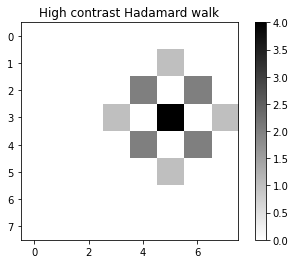

[[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 3. 0. 3. 0.]
 [0. 0. 0. 3. 0. 9. 0. 3.]
 [1. 0. 1. 0. 9. 0. 9. 0.]
 [0. 0. 0. 3. 0. 9. 0. 3.]
 [0. 0. 0. 0. 3. 0. 3. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


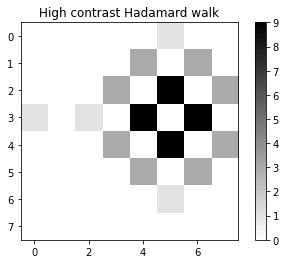

[[ 0.  0.  0.  0.  4.  0.  4.  0.]
 [ 0.  0.  0.  6.  0. 16.  0.  6.]
 [ 4.  0.  4.  0. 24.  0. 24.  0.]
 [ 0.  2.  0. 16.  0. 36.  0. 16.]
 [ 4.  0.  4.  0. 24.  0. 24.  0.]
 [ 0.  0.  0.  6.  0. 16.  0.  6.]
 [ 0.  0.  0.  0.  4.  0.  4.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.  0.]]


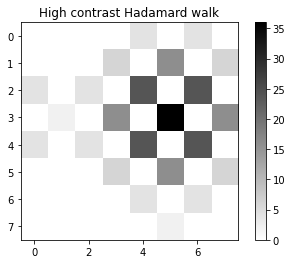

[[  0.   0.   0.  10.   0.  26.   0.  10.]
 [ 10.   0.  10.   0.  50.   0.  50.   0.]
 [  0.  10.   0.  50.   0. 100.   0.  50.]
 [ 26.   0.  26.   0. 100.   0. 100.   0.]
 [  0.  10.   0.  50.   0. 100.   0.  50.]
 [ 10.   0.  10.   0.  50.   0.  50.   0.]
 [  0.   0.   0.  10.   0.  26.   0.  10.]
 [  0.   0.   0.   0.  10.   0.  10.   0.]]


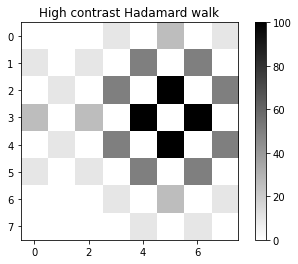

[[ 20.   0.  20.   0.  96.   0.  96.   0.]
 [  0.  30.   0. 120.   0. 226.   0. 120.]
 [ 96.   0.  96.   0. 300.   0. 300.   0.]
 [  0.  72.   0. 226.   0. 400.   0. 226.]
 [ 96.   0.  96.   0. 300.   0. 300.   0.]
 [  0.  30.   0. 120.   0. 226.   0. 120.]
 [ 20.   0.  20.   0.  96.   0.  96.   0.]
 [  0.   0.   0.  30.   0.  72.   0.  30.]]


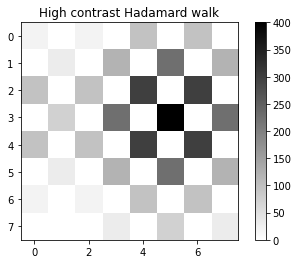

[[   0.   70.    0.  266.    0.  490.    0.  266.]
 [ 266.    0.  266.    0.  742.    0.  742.    0.]
 [   0.  294.    0.  742.    0. 1226.    0.  742.]
 [ 490.    0.  490.    0. 1226.    0. 1226.    0.]
 [   0.  294.    0.  742.    0. 1226.    0.  742.]
 [ 266.    0.  266.    0.  742.    0.  742.    0.]
 [   0.   70.    0.  266.    0.  490.    0.  266.]
 [  70.    0.   70.    0.  294.    0.  294.    0.]]


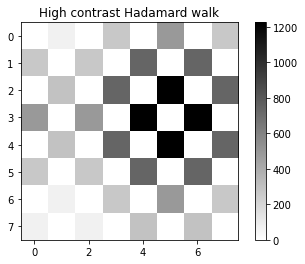

[[ 672.    0.  672.    0. 1792.    0. 1792.    0.]
 [   0.  896.    0. 2016.    0. 3200.    0. 2016.]
 [1792.    0. 1792.    0. 3936.    0. 3936.    0.]
 [   0. 1568.    0. 3200.    0. 4904.    0. 3200.]
 [1792.    0. 1792.    0. 3936.    0. 3936.    0.]
 [   0.  896.    0. 2016.    0. 3200.    0. 2016.]
 [ 672.    0.  672.    0. 1792.    0. 1792.    0.]
 [   0.  280.    0.  896.    0. 1568.    0.  896.]]


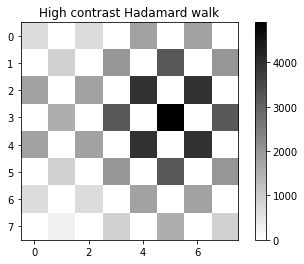

[[    0.  2520.     0.  5376.     0.  8352.     0.  5376.]
 [ 5376.     0.  5376.     0. 10944.     0. 10944.     0.]
 [    0.  6048.     0. 10944.     0. 15976.     0. 10944.]
 [ 8352.     0.  8352.     0. 15976.     0. 15976.     0.]
 [    0.  6048.     0. 10944.     0. 15976.     0. 10944.]
 [ 5376.     0.  5376.     0. 10944.     0. 10944.     0.]
 [    0.  2520.     0.  5376.     0.  8352.     0.  5376.]
 [ 2520.     0.  2520.     0.  6048.     0.  6048.     0.]]


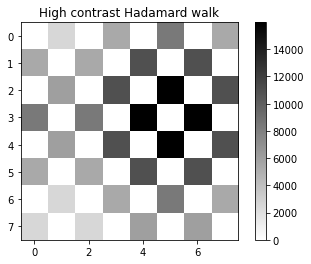

[[15792.     0. 15792.     0. 30720.     0. 30720.     0.]
 [    0. 19320.     0. 32640.     0. 46216.     0. 32640.]
 [30720.     0. 30720.     0. 53840.     0. 53840.     0.]
 [    0. 28800.     0. 46216.     0. 63904.     0. 46216.]
 [30720.     0. 30720.     0. 53840.     0. 53840.     0.]
 [    0. 19320.     0. 32640.     0. 46216.     0. 32640.]
 [15792.     0. 15792.     0. 30720.     0. 30720.     0.]
 [    0. 10080.     0. 19320.     0. 28800.     0. 19320.]]


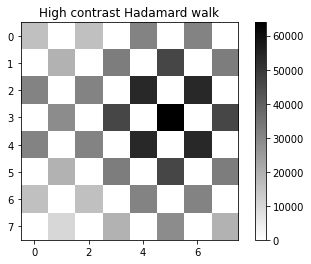

In [19]:
g = sg
# print(g)
plt.title("High contrast Hadamard walk")

pixel_plot = plt.imshow(
  g, cmap='binary')

plt.colorbar(pixel_plot)
plt.show(pixel_plot)
    
# iterate    
for i in range(iterations):
    g = grid_step(g)
    
    
    plt.title("High contrast Hadamard walk")
    pixel_plot = plt.imshow(
      g, cmap='binary')

    print(g)
    plt.colorbar(pixel_plot)
    plt.show(pixel_plot)